*Import required libraries and modules*

In [1]:
import random 

import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from skimage.feature import hog


from matplotlib import pyplot as plt

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

Read the Dataset



In [2]:
# import the necessary packages
import os

image_types = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")


def list_images(basePath, contains=None):
    return list_files(basePath, validExts=image_types, contains=contains)


def list_files(basePath, validExts=None, contains=None):
    # loop over the directory structure
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        # loop over the filenames in the current directory
        for filename in filenames:
            # if the contains string is not none and the filename does not contain
            # the supplied string, then ignore the file
            if contains is not None and filename.find(contains) == -1:
                continue

            # determine the file extension of the current file
            ext = filename[filename.rfind("."):].lower()

            # check to see if the file is an image and should be processed
            if validExts is None or ext.endswith(validExts):
                # construct the path to the image and yield it
                imagePath = os.path.join(rootDir, filename)
                yield imagePath

imagePaths = list(list_images('../input/dulieukhuonmat'))

Read and convert images into gray-scale



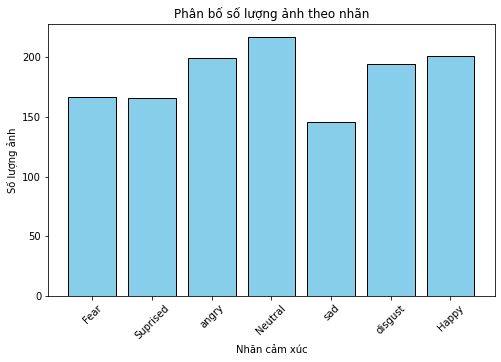

In [3]:
basePath = '../input/dulieukhuonmat'

# Tạo dict đếm số ảnh mỗi nhãn
label_counts = {}

for label in os.listdir(basePath):
    label_path = os.path.join(basePath, label)
    if os.path.isdir(label_path):  # chỉ lấy folder
        num_images = len([f for f in os.listdir(label_path) 
                          if f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"))])
        label_counts[label] = num_images

# Vẽ biểu đồ cột
plt.figure(figsize=(8,5))
plt.bar(label_counts.keys(), label_counts.values(), color="skyblue", edgecolor="black")
plt.xlabel("Nhãn cảm xúc")
plt.ylabel("Số lượng ảnh")
plt.title("Phân bố số lượng ảnh theo nhãn")
plt.xticks(rotation=45)
plt.show()

In [4]:
def colortogray(im):
    image = cv2.imread(im)
    imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return imgray

Resize images with a fixed size(INTER LINEAR interpolation)



In [5]:
def resizeImage(image, size):
    # cv2.imshow('Resized', cv2.resize(image, (size,size), interpolation=cv2.INTER_CUBIC))
    return cv2.resize(image, (size,size))

Features extraction with HOG algorithm



In [6]:
def feat_lab(imagePaths):
    features = []
    labels = []
    images = []   # lưu thêm ảnh gốc

    for imagePath in imagePaths:
        im = colortogray(imagePath)
        im_resized = resizeImage(im, 48)
        
        fd1 = hog(im_resized, orientations=9, pixels_per_cell=(8, 8),
                  cells_per_block=(2, 2), block_norm='L2-Hys', transform_sqrt=False)

        label = imagePath.split(os.path.sep)[-2]
        labels.append(label)
        features.append(fd1)
        images.append(im_resized)   # lưu ảnh gốc (sau resize) 

    return np.array(features), np.array(labels), np.array(images)

Compute the features and obtain the lables using the previous functions



In [7]:
features, labels, images = feat_lab(imagePaths)


print("[INFO] The number of features ..." + str(features.shape[1]))

print("[INFO] The number of samples ..." + str(labels.shape[0]))

[INFO] The number of features ...900
[INFO] The number of samples ...1290


The classifier

In [8]:
svm_clf = SVC(kernel='rbf', gamma='scale', C= 0.45)

In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = classification_report(y_train, pred)
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = classification_report(y_test, pred)
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

################################################################################
################################################################################

R =random.randint(1,88)
X_train, X_test, y_train, y_test, img_train, img_test = train_test_split(
    features, labels, images, test_size=0.3, random_state=40
)

print("[INFO] The number of images used in training ..." + str(X_train.shape[0]))
print("[INFO] The number of images used in testing ..." + str(X_test.shape[0]))

from sklearn.preprocessing import StandardScaler


svm_clf.fit(X_train, y_train)
from joblib import dump, load

# Save model
dump(svm_clf, '/kaggle/working/svm_model.joblib')

print("Model đã được lưu thành công!")
print_score(svm_clf, X_train, y_train, X_test, y_test, train=True)
print_score(svm_clf, X_train, y_train, X_test, y_test, train=False)


[INFO] The number of images used in training ...903
[INFO] The number of images used in testing ...387
Model đã được lưu thành công!
Train Result:
Accuracy Score: 81.28%
_______________________________________________
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        Fear       0.76      0.75      0.76       120
       Happy       0.80      0.92      0.86       146
     Neutral       0.88      0.89      0.88       150
    Suprised       0.88      0.87      0.87       121
       angry       0.72      0.88      0.79       138
     disgust       0.83      0.73      0.78       127
         sad       0.89      0.55      0.68       101

    accuracy                           0.81       903
   macro avg       0.82      0.80      0.80       903
weighted avg       0.82      0.81      0.81       903

_______________________________________________
Confusion Matrix: 
 [[ 90   1   3   9   5   9   3]
 [  2 135   1   0   8   0   0]
 [  1   3 133   1  10   1   1]
 

**Cross-validation accuracy**

*3-FOLDS*

In [10]:
cv = KFold(n_splits=3, random_state=1, shuffle=True)
# evaluate model
scores = cross_val_score(svm_clf, features, labels, scoring='accuracy', cv=cv, n_jobs=-1)
# Report performance

print('SVM MEAN  Accuracy: ',str(np.mean(scores)*100)[:5] + '%')
print('Standard deviation: ',str(np.std(scores)*100)[:5] + '%')

SVM MEAN  Accuracy:  54.03%
Standard deviation:  3.770%


*5-FOLDS*

In [11]:
cv = KFold(n_splits=5, random_state=1, shuffle=True)
# evaluate model
scores = cross_val_score(svm_clf, features, labels, scoring='accuracy', cv=cv, n_jobs=-1)
# Report performance

print('SVM MEAN  Accuracy: ',str(np.mean(scores)*100)[:5] + '%')
print('Standard deviation: ',str(np.std(scores)*100)[:5] + '%')

SVM MEAN  Accuracy:  55.81%
Standard deviation:  1.607%


10-FOLDS

In [12]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
# evaluate model
scores = cross_val_score(svm_clf, features, labels, scoring='accuracy', cv=cv, n_jobs=-1)
# Report performance

print('SVM MEAN  Accuracy: ',str(np.mean(scores)*100)[:5] + '%')
print('Standard deviation: ',str(np.std(scores)*100)[:5] + '%')

SVM MEAN  Accuracy:  57.90%
Standard deviation:  4.372%


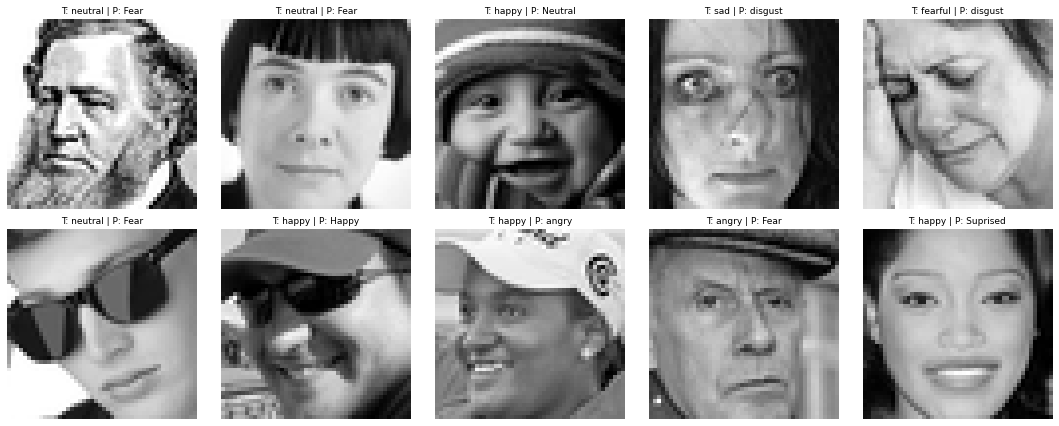

In [13]:
imagePathss = list(list_images('../input/emotion-detection-fer/test/'))
featuress, labelss, imagess = feat_lab(imagePathss)


plt.figure(figsize=(15,6))

X_trains, X_tests, y_trains, y_tests, img_train, img_tests = train_test_split(
    featuress, labelss, imagess, test_size=0.3, random_state=40
)
idxs = np.random.choice(len(X_tests), 10, replace=False)

# Lặp qua 10 chỉ mục ngẫu nhiên để hiển thị ảnh
for i, idx in enumerate(idxs):
    img = img_tests[idx]  # Sử dụng ảnh đã qua xử lý

    # Khôi phục ảnh về dạng 64x64 (hoặc kích thước gốc ban đầu) nếu ảnh bị làm phẳng
    img = img.reshape(48, 48)  # Điều chỉnh này phù hợp với kích thước gốc

    # Dự đoán nhãn và lấy nhãn thực tế
    pred = svm_clf.predict([X_tests[idx]])[0]  # Dự đoán từ mô hình
    true = y_tests[idx]  # Nhãn thực tế

    # Hiển thị ảnh đã xử lý
    plt.subplot(2, 5, i+1)  # Tạo grid 2 hàng và 5 cột
    plt.imshow(img, cmap="gray")  # Hiển thị ảnh theo kiểu grayscale
    plt.title(f"T: {true} | P: {pred}", fontsize=9)  # In nhãn thực tế và dự đoán
    plt.axis("off")  # Tắt trục để dễ nhìn ảnh hơn

plt.tight_layout()  # Căn chỉnh các ảnh
plt.show()

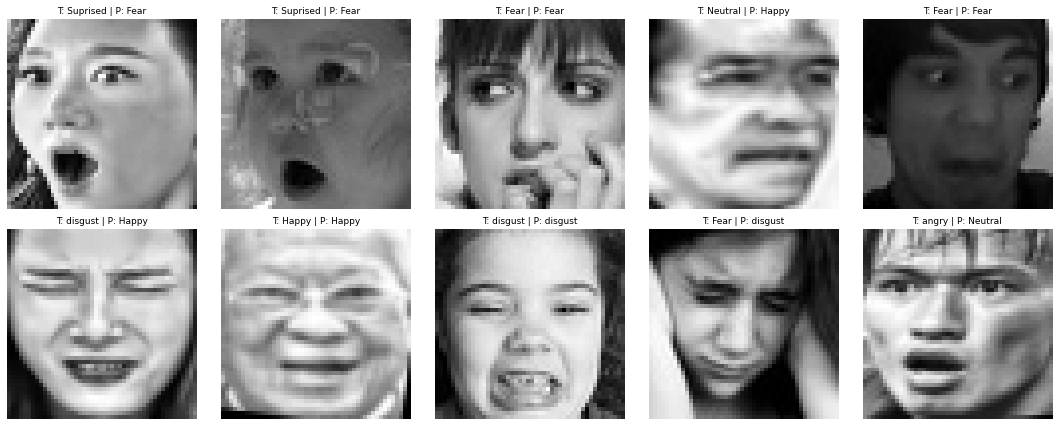

In [14]:


# Giả sử ảnh đã qua xử lý và bị làm phẳng thành vector 2800 phần tử
# Lấy 10 chỉ mục ngẫu nhiên từ X_test
idxs = np.random.choice(len(X_test), 10, replace=False)

plt.figure(figsize=(15,6))

# Lặp qua 10 chỉ mục ngẫu nhiên để hiển thị ảnh
for i, idx in enumerate(idxs):
    img = img_test[idx]  # Sử dụng ảnh đã qua xử lý

    # Khôi phục ảnh về dạng 64x64 (hoặc kích thước gốc ban đầu) nếu ảnh bị làm phẳng
    img = img.reshape(48, 48)  # Điều chỉnh này phù hợp với kích thước gốc

    # Dự đoán nhãn và lấy nhãn thực tế
    pred = svm_clf.predict([X_test[idx]])[0]  # Dự đoán từ mô hình
    true = y_test[idx]  # Nhãn thực tế

    # Hiển thị ảnh đã xử lý
    plt.subplot(2, 5, i+1)  # Tạo grid 2 hàng và 5 cột
    plt.imshow(img, cmap="gray")  # Hiển thị ảnh theo kiểu grayscale
    plt.title(f"T: {true} | P: {pred}", fontsize=9)  # In nhãn thực tế và dự đoán
    plt.axis("off")  # Tắt trục để dễ nhìn ảnh hơn

plt.tight_layout()  # Căn chỉnh các ảnh
plt.show()


Train Accuracy: 0.8128460686600222
Test Accuracy: 0.5917312661498708
Classification Report:
               precision    recall  f1-score   support

        Fear       0.48      0.55      0.51        47
       Happy       0.53      0.69      0.60        55
     Neutral       0.74      0.69      0.71        67
    Suprised       0.68      0.62      0.65        45
       angry       0.54      0.80      0.64        61
     disgust       0.61      0.46      0.53        67
         sad       0.69      0.24      0.36        45

    accuracy                           0.59       387
   macro avg       0.61      0.58      0.57       387
weighted avg       0.61      0.59      0.58       387

Confusion Matrix:
 [[26  1  2  7  1 10  0]
 [ 2 38  2  0 12  1  0]
 [ 2  8 46  0  6  0  5]
 [10  1  1 28  3  2  0]
 [ 0  8  2  0 49  2  0]
 [12  7  1  5 11 31  0]
 [ 2  9  8  1  9  5 11]]


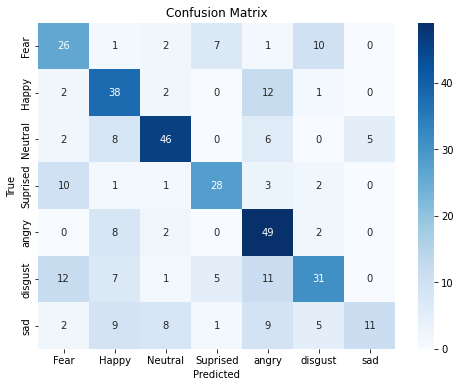

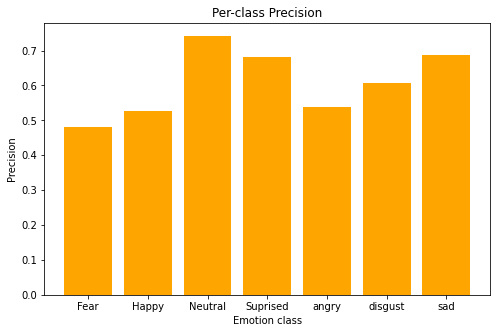

In [15]:
# Train
pred_train = svm_clf.predict(X_train)
print("Train Accuracy:", accuracy_score(y_train, pred_train))

# Test
pred_test = svm_clf.predict(X_test)   # 🔥 thêm dòng này
print("Test Accuracy:", accuracy_score(y_test, pred_test))
print("Classification Report:\n", classification_report(y_test, pred_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, pred_test))
# 1. Confusion Matrix
cm = confusion_matrix(y_test, pred_test)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 2. Accuracy từng lớp (bar chart)
report = classification_report(y_test, pred_test, output_dict=True)
class_acc = [report[str(c)]['precision'] for c in np.unique(y_test)]

plt.figure(figsize=(8,5))
plt.bar(np.unique(y_test), class_acc, color="orange")
plt.xlabel("Emotion class")
plt.ylabel("Precision")
plt.title("Per-class Precision")
plt.show()